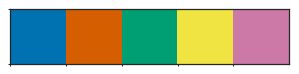

In [3]:
import sys
import os
from glob import glob
import re
import itertools as it

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns

import pyBigWig as pybw
from pysam import AlignmentFile

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [12]:
%%bash
source activate jupyter_python3

faOneRecord \
  /home/matthew/Documents/genomes/tair10/fasta/tair10_cdna.fa \
  "AT3G28550.1" > ./ext9.fa

In [21]:
with open('./ext9.fa') as f:
    seq = ''.join(f.readlines()[1:]).replace('\n', '')

In [50]:
def sim(a, b):
    return sum([i == j for i, j in zip(a, b)])
slen = len(seq)
dotplot = np.zeros((slen, slen), dtype='f')
k = 15
h = k // 2
r = list(range(h, slen - h - 1))
for i, j in it.product(r, r):
    dotplot[i, j] = sim(seq[i - h: i + h + 1], seq[j - h: j + h + 1])
dotplot /= k

In [ ]:
cax.ax.set_ylim

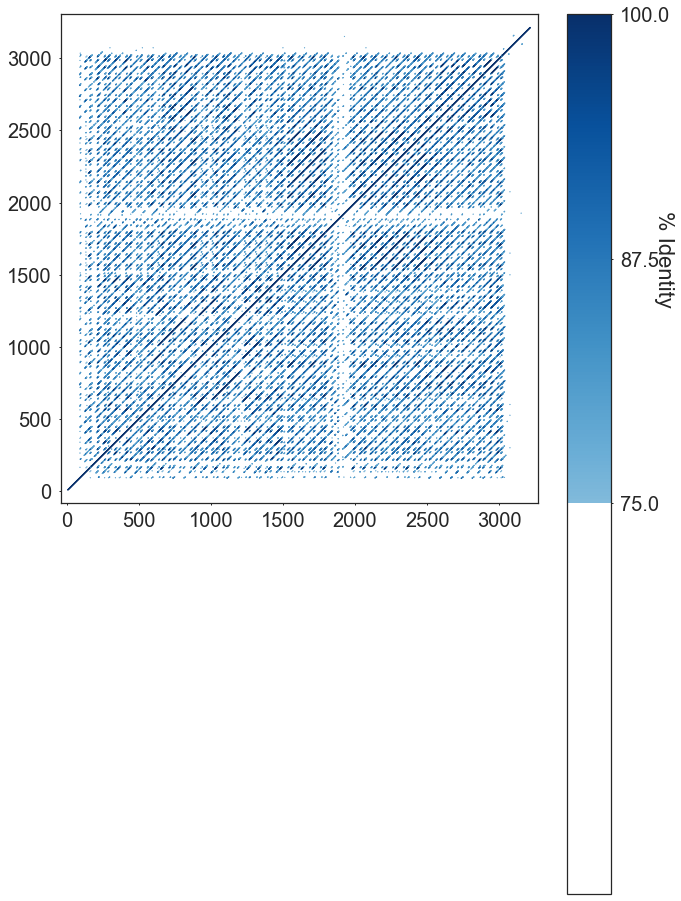

In [140]:
d = dotplot.copy()
d[d < 0.75] = 0
x, y = np.nonzero(d)
s = d[x, y]

fig, ax = plt.subplots(figsize=(10, 8))
plt.axis('equal')
c = ScalarMappable(Normalize(55, 100), cmap='Blues')
c.set_array(s)
ax.scatter(x=x,
           y=y,
           c=[c.to_rgba(i * 100) for i in s],
           s=s,
           rasterized=True)
ax.set_xlim(0, slen)
ax.set_ylim(0, slen)
cbar = plt.colorbar(c)
cbar.set_label('% Identity', rotation=270)
cbar.set_ticks([75, 87.5, 100])
cbar.ax.set_ylim(0.4444444444, 1)
plt.tight_layout()
plt.savefig('ext9_self_identity.svg')
plt.show()

In [4]:
genes = pd.read_table('/home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed',
                      names=['chrom', 'start', 'end', 'gene_id', '_', 'strand'],
                      usecols=[0, 1, 2, 3, 5])
genes.head()

,chrom,start,end,gene_id,strand
0,1,3631,5899,AT1G01010,+
1,1,6788,9130,AT1G01020,-
2,1,11101,11372,AT1G03987,+
3,1,11649,13714,AT1G01030,-
4,1,23121,31227,AT1G01040,+


In [7]:
extensins = set('''
At3g28550
At5g35190
At5g06640
At2g24980
At4g08400
At3g54590
At1g23720
At1g12040
At5g06630
At3g54580
At4g08410
At5g19800
At3g19430
At5g26080
At4g32710
At3g24480
At1g52290
At4g13390
At1g62440
At4g18670
At1g26150
At3g06750
At4g13340
At4g16140
At1g70460
At3g11030
At4g22470
At1g70990
At1g26250
At3g22800
At5g38560
At3g20850
At3g49270
At2g43150
At5g19810
At1g23540
At3g19020
At3g24550
At1g21310
At4g08370
At3g24540
At1g49490
At2g18470
At1g76930
At1g54215
At1g49270
At5g49280
At1g23040
At5g11990
At3g50580
At4g33970
At5g25550
At2g15880
At4g11430
At1g10620
At1g02405
At3g18810
At3g53330
At4g08380
At1g62760
At4g34440
at1g26240
At5g49080
'''.upper().strip().split())

extensins = genes[genes.gene_id.isin(extensins)]
extensins.head()

,chrom,start,end,gene_id,strand
182,1,489874,490627,AT1G02405,-
1248,1,3509001,3512321,AT1G10620,-
1442,1,4069992,4072681,AT1G12040,+
2601,1,7453245,7455009,AT1G21310,-
2816,1,8164782,8166716,AT1G23040,+


In [60]:
%%bash
source activate cgat_python2
cgat gtf2gtf --method=merge-exons --filter=proteincoding \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null | 
awk -v OFS='\t' '$3 == "exon" {print $10}' | 
sed -e 's/[";]//g' | uniq -c | 
awk -v OFS='\t' '{print $2, $1}' > araport_n_exons.tsv

In [62]:
exons = pd.read_table('./araport_n_exons.tsv',
                      sep='\t', names=['gene_id', 'n_exons'])
exons.head()

,gene_id,n_exons
0,AT1G01010,6
1,AT1G01020,7
2,AT1G03987,1
3,AT1G01030,2
4,AT1G01040,20


In [64]:
intronless_ext = extensins[extensins.gene_id.isin(exons[exons.n_exons == 1].gene_id)]

In [112]:
SRRs = ['SRR3664422', 'SRR3664423', 'SRR3664424']
fpath = '/home/matthew/sharc_fastdata/tair10_splicing_benfey/{}.star.bam'

bams = [AlignmentFile(fpath.format(x)) for x in SRRs]
mappability = pybw.open('./tair10.mappability75mer.bw')

mappability_splicing = {}

for _, chrom, start, end, gene_id, strand in intronless_ext.itertuples():
    total_reads = []
    spliced_reads = []
    percent_spliced = []
    for b in bams:
        reads = b.fetch(chrom, start, end)
        tot = 0
        splic = 0
        for r in reads:
            if r.reference_start > start and r.reference_end < end:
                tot += 1
                if 'N' in r.cigarstring:
                    splic += 1
        total_reads.append(tot)
        spliced_reads.append(splic)
        percent_spliced.append(((splic + 1) / (tot + 1)) * 100)
    mapp = np.array(mappability.values(chrom, int(start), int(end)))
    mapp_perc = np.percentile(mapp, [0, 25, 50, 75, 100])
    mapp_avg = mapp.mean()
    mappability_splicing[gene_id] = (*total_reads, 
                                     *spliced_reads,
                                     *percent_spliced,
                                     *mapp_perc, mapp_avg)
mappability_splicing = pd.DataFrame.from_dict(mappability_splicing, orient='index')
mappability_splicing.columns = ['rep_1_tot_reads', 'rep_2_tot_reads', 'rep_3_tot_reads',
                                'rep_1_splic_reads', 'rep_2_splic_reads', 'rep_3_splic_reads',
                                'rep_1_percent_splic', 'rep_2_percent_splic', 'rep_3_percent_splic',
                                'mappability_min', 'mappability_q1', 'mappability_med',
                                'mappability_q2', 'mappability_max', 'mappability_mean']
mappability_splicing.head()

,rep_1_tot_reads,rep_2_tot_reads,rep_3_tot_reads,rep_1_splic_reads,rep_2_splic_reads,rep_3_splic_reads,rep_1_percent_splic,rep_2_percent_splic,rep_3_percent_splic,mappability_min,mappability_q1,mappability_med,mappability_q2,mappability_max,mappability_mean
AT3G22800,20492,15689,13204,28,26,9,0.141512,0.172084,0.075729,0.500000,1.0,1.0,1.0,1.0,0.999226
AT1G54215,28,18,34,0,0,0,3.448276,5.263158,2.857143,1.000000,1.0,1.0,1.0,1.0,1.000000
AT5G19810,10,2,22,0,0,0,9.090909,33.333333,4.347826,0.333333,1.0,1.0,1.0,1.0,0.960545
AT1G02405,2,13,11,0,0,0,33.333333,7.142857,8.333333,1.000000,1.0,1.0,1.0,1.0,1.000000
AT5G11990,62,65,16,0,0,0,1.587302,1.515152,5.882353,1.000000,1.0,1.0,1.0,1.0,1.000000


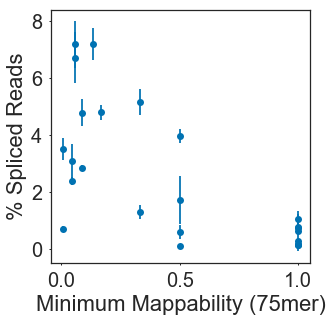

In [127]:
mappability_splicing['percent_spliced_mean'] = mappability_splicing[
    ['rep_1_percent_splic', 'rep_2_percent_splic', 'rep_3_percent_splic']
].mean(1)

mappability_splicing['mean_expression'] = mappability_splicing[
    ['rep_1_tot_reads', 'rep_2_tot_reads', 'rep_3_tot_reads']
].mean(1)

mappability_splicing['percent_spliced_std'] = mappability_splicing[
    ['rep_1_percent_splic', 'rep_2_percent_splic', 'rep_3_percent_splic']
].std(1)

fig, ax = plt.subplots(figsize=(5, 5))
m = mappability_splicing[mappability_splicing.mean_expression > 100]
ax.errorbar(y=m.percent_spliced_mean,
            x=m.mappability_min,
            yerr=m.percent_spliced_std,
            marker='o',
            linestyle='none')
ax.set_xlabel('Minimum Mappability (75mer)')
ax.set_ylabel('% Spliced Reads')
plt.tight_layout()
plt.savefig('mappability_vs_splicing.svg')
plt.show()

In [104]:
mappability_splicing.sort_values('percent_spliced_mean')

,rep_1_tot_reads,rep_2_tot_reads,rep_3_tot_reads,rep_1_splic_reads,rep_2_splic_reads,rep_3_splic_reads,rep_1_percent_splic,rep_2_percent_splic,rep_3_percent_splic,mappability_min,mappability_median,mappability_mean,percent_spliced_mean,mean_expression,percent_spliced_std
AT3G22800,20492,15689,13204,28,26,9,0.141512,0.172084,0.075729,0.500000,1.000000,0.999226,0.129775,16461.666667,0.049238
AT3G06750,1358,731,1065,0,1,0,0.073584,0.273224,0.093809,1.000000,1.000000,1.000000,0.146872,1051.333333,0.109890
AT5G49280,3474,2052,2697,1,5,3,0.057554,0.292255,0.148258,1.000000,1.000000,1.000000,0.166022,2741.000000,0.118355
AT1G70990,1445,830,954,0,0,2,0.069156,0.120337,0.314136,1.000000,1.000000,1.000000,0.167876,1076.333333,0.129224
AT5G19800,580,345,428,1,0,0,0.344234,0.289017,0.233100,1.000000,1.000000,1.000000,0.288784,451.000000,0.055567
AT4G22470,2632,2279,1344,8,18,8,0.341815,0.833333,0.669145,0.500000,1.000000,0.968845,0.614765,2085.000000,0.250231
AT1G49490,487,358,564,6,0,0,1.434426,0.278552,0.176991,1.000000,1.000000,1.000000,0.629990,469.666667,0.698511
AT1G12040,19922,11651,15865,144,91,98,0.727802,0.789564,0.623976,0.008972,1.000000,0.987179,0.713781,15812.666667,0.083680
AT3G24480,28039,22971,19318,254,174,105,0.909415,0.761797,0.548683,1.000000,1.000000,1.000000,0.739965,23442.666667,0.181355
AT1G62440,4278,2244,3254,33,21,18,0.794578,0.979955,0.583717,1.000000,1.000000,1.000000,0.786084,3258.666667,0.198256


In [37]:
mappability_splicing[mappability_splicing.rep_1_tot_reads > 50].sort_values('mappability_mean')

,rep_1_tot_reads,rep_2_tot_reads,rep_3_tot_reads,rep_1_splic_reads,rep_2_splic_reads,rep_3_splic_reads,rep_1_percent_splic,rep_2_percent_splic,rep_3_percent_splic,mappability_min,mappability_median,mappability_mean
AT4G08410,17419,8657,9786,645,295,322,3.708381,3.418803,3.300296,0.046625,0.500000,0.441178
AT4G08400,15824,7918,8875,592,237,227,3.747235,3.005430,2.568725,0.046625,0.500000,0.459440
AT2G24980,14374,8021,9732,1154,566,604,8.034783,7.068063,6.215966,0.057354,0.333333,0.508780
AT5G06630,4684,2122,2709,457,180,291,9.775880,8.525671,10.774908,0.057354,0.500000,0.606669
AT3G28550,226102,149806,149023,19432,12861,11027,8.594755,8.585714,7.400150,0.133631,1.000000,0.737199
AT3G54580,188675,113691,132686,27120,16226,18442,14.374377,14.272772,13.899628,0.166667,1.000000,0.754538
AT3G54590,68066,39836,45057,20672,11898,13970,30.371546,29.869217,31.006702,0.087039,1.000000,0.793859
AT1G76930,111530,71831,69380,14099,10012,10350,12.642225,13.939470,14.919070,0.166667,1.000000,0.820075
AT5G06640,7062,3603,4016,386,159,200,5.479258,4.439512,5.003734,0.087039,1.000000,0.853928
AT1G21310,469525,311895,288271,39012,28608,27914,8.309018,9.172609,9.683563,0.250000,1.000000,0.876275
